In [1]:
import supereeg as se
import pandas as pd
import numpy as np
import os
import hypertools as hyp
import plot as plot
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting as ni_plt
import scipy.spatial as spatial
import scipy.stats as stats

In [2]:
fig_dir = '../../paper/figs/source/best_locs'

In [3]:
ram_data_dir = '../../data/ram'
pyfr_data_dir = '../../data/pyfr'

In [4]:
fig_count = 0

# PyFR analysis

In [5]:
pyFR_df = pd.read_csv(os.path.join(pyfr_data_dir, 'pyfr.csv'), index_col=0)

In [6]:
pyFR_df['across'] = plot.r2z(pyFR_df['across'])
pyFR_df['within'] = plot.r2z(pyFR_df['within'])

In [7]:
grouped_pyfr_mean = pyFR_df.groupby('Subject')['across','within'].mean()

In [8]:
pyFR_df['Subject'].shape

(4168,)

## Replace correlation for each electrode with the average correlation for each subject 

In [9]:
corr_by_subject = np.array([])
R_locs = []
subj_by_subject = np.array([])
for i, s in enumerate(grouped_pyfr_mean.index):


    sub_locs = plot.compile_df_locs(pyFR_df['R'][pyFR_df['Subject'] == s])

    if R_locs == []:
        R_locs = sub_locs 
    else:

        R_locs = np.vstack((R_locs, sub_locs))

    sub_corr = np.atleast_2d(grouped_pyfr_mean['across'][i])
 
    corr_by_subject = np.append(corr_by_subject, np.array([grouped_pyfr_mean['across'][i]]* np.shape(sub_locs)[0]))
    
    subj_by_subject = np.append(subj_by_subject, np.array([str(s)]* np.shape(sub_locs)[0]))



bestloc_pyfr_df = pd.DataFrame()
bestloc_pyfr_df['Correlation'] = plot.z2r(corr_by_subject)
bestloc_pyfr_df['Subject'] = subj_by_subject
bestloc_pyfr_df['R'] = None



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


In [10]:
# # This loop takes a while, so I saved the output and input it later to make it faster
# for i in range(bestloc_pyfr_df.shape[0]):
#     bestloc_pyfr_df['R'][i] = str(R_locs[i])

# bestloc_pyfr_df.to_csv(os.path.join(pyfr_data_dir, 'best_locs.csv'))

In [11]:
bestloc_pyfr_df = pd.read_csv(os.path.join(pyfr_data_dir, 'best_locs.csv'), index_col=0)

In [12]:
bestloc_pyfr_df.head()

,Correlation,Subject,R
0,0.684209,0,[42.42 -9.47 25.62]
1,0.684209,0,[ 40.4 10.97 -14.86]
2,0.684209,0,[ 35.35 -19.92 -40.48]
3,0.684209,0,[ 51.52 -22.65 -25.15]
4,0.684209,0,[ 54.55 -34.13 1.46]


In [13]:
bo_locs = plot.compile_df_locs(bestloc_pyfr_df[bestloc_pyfr_df['Subject']==0]['R'])
bo_corr = bestloc_pyfr_df[bestloc_pyfr_df['Subject']==0]['Correlation'].values

In [14]:
bo_corr

array([0.68420924, 0.68420924, 0.68420924, 0.68420924, 0.68420924,
       0.68420924, 0.68420924, 0.68420924, 0.68420924, 0.68420924,
       0.68420924, 0.68420924, 0.68420924, 0.68420924, 0.68420924,
       0.68420924, 0.68420924, 0.68420924, 0.68420924, 0.68420924,
       0.68420924, 0.68420924, 0.68420924, 0.68420924, 0.68420924,
       0.68420924, 0.68420924, 0.68420924, 0.68420924, 0.68420924,
       0.68420924, 0.68420924, 0.68420924, 0.68420924, 0.68420924,
       0.68420924, 0.68420924, 0.68420924, 0.68420924, 0.68420924,
       0.68420924, 0.68420924, 0.68420924, 0.68420924, 0.68420924,
       0.68420924, 0.68420924, 0.68420924, 0.68420924, 0.68420924,
       0.68420924, 0.68420924, 0.68420924, 0.68420924])

/usr/local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


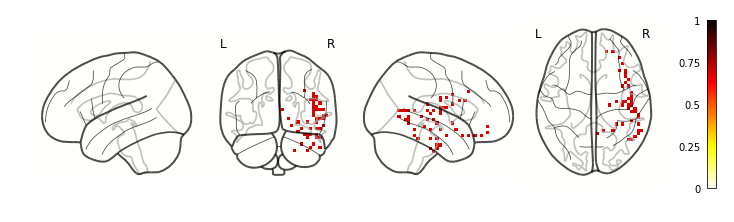

In [15]:
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(bo_corr), locs=bo_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')

In [16]:
all_locs = plot.compile_df_locs(bestloc_pyfr_df['R'])
all_corr = np.atleast_2d(bestloc_pyfr_df['Correlation'])

## Plot patient average correlation at each electrode location

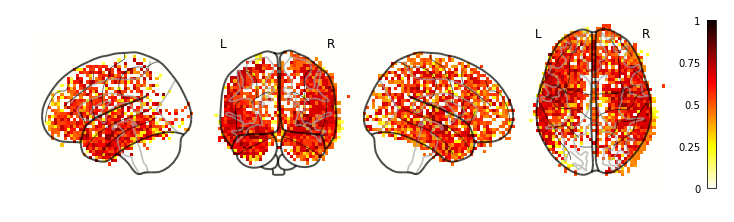

In [17]:
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=all_corr, locs=all_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')

In [18]:
bestloc_pyfr_df.head()

,Correlation,Subject,R
0,0.684209,0,[42.42 -9.47 25.62]
1,0.684209,0,[ 40.4 10.97 -14.86]
2,0.684209,0,[ 35.35 -19.92 -40.48]
3,0.684209,0,[ 51.52 -22.65 -25.15]
4,0.684209,0,[ 54.55 -34.13 1.46]


## Plot most informative location (average correlation of subject with electrodes within 5 mni of each location in 4mm brain)

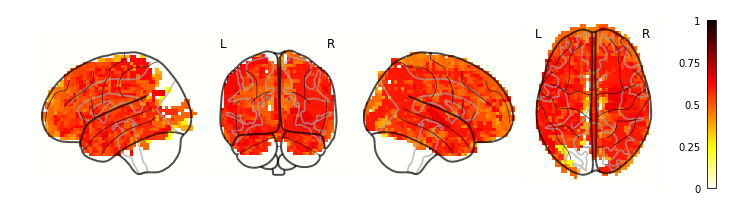

In [19]:
plot.most_informative_locs_plot(bestloc_pyfr_df, vox_size=4, width=5)

## Same but for 20 mm

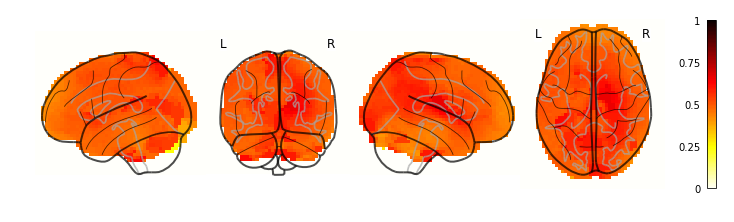

In [20]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.most_informative_locs_plot(bestloc_pyfr_df, vox_size=4, width=20, outfile=outfile)

In [21]:
most_info_pyfr = plot.most_informative_locs(bestloc_pyfr_df, vox_size=4, width=20)

# RAM

In [22]:
RAM_df = pd.read_csv(os.path.join(ram_data_dir, 'ram.csv'), index_col=0)

## FR

In [23]:
str_find = '_FR1'
str_find
FR_df = RAM_df[RAM_df['Experiment'].str.contains(str_find)]

In [24]:
fr_locs = plot.compile_df_locs(FR_df['R'])

In [25]:
fr_subject = np.array([])
fr_within = np.array([])
fr_across = np.array([])
fr_R = np.array([])
for i , item in enumerate(FR_df['Subject'].values):
    fr_subject = np.append(fr_subject, item)
    fr_within = np.append(fr_within, FR_df['W_w_w'].iloc[i])
    fr_across = np.append(fr_across, FR_df['W_a_w'].iloc[i])
    fr_R = np.append(fr_R, FR_df['R'].iloc[i])

In [26]:
corr_fr_df = pd.DataFrame()
corr_fr_df['Subject'] = fr_subject
corr_fr_df['W_w_w'] = plot.r2z(fr_within)
corr_fr_df['W_a_w'] = plot.r2z(fr_across)
corr_fr_df['R'] = fr_R

In [27]:
fr_locs = plot.compile_df_locs(corr_fr_df['R'])

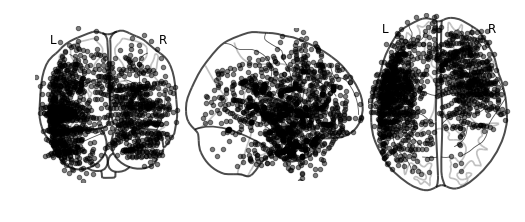

In [28]:
ni_plt.plot_connectome(np.eye(fr_locs.shape[0]), fr_locs,
                       node_kwargs={'alpha':.5, 'edgecolors': None, 'cmap':'hot'},
                       node_size=20, node_color='k')

## CatFR

In [29]:
str_find = '_CatFR1'
str_find
CatFR_df = RAM_df[RAM_df['Experiment'].str.contains(str_find)]

In [30]:
catfr_subject = np.array([])
catfr_within = np.array([])
catfr_across = np.array([])
catfr_R = np.array([])
for i , item in enumerate(CatFR_df['Subject'].values):
    catfr_subject = np.append(catfr_subject, item)
    catfr_within = np.append(catfr_within, CatFR_df['W_w_w'].iloc[i])
    catfr_across = np.append(catfr_across, CatFR_df['W_a_w'].iloc[i])
    catfr_R = np.append(catfr_R, CatFR_df['R'].iloc[i])

In [31]:
corr_catfr_df = pd.DataFrame()
corr_catfr_df['Subject'] = catfr_subject
corr_catfr_df['W_w_w'] = plot.r2z(catfr_within)
corr_catfr_df['W_a_w'] = plot.r2z(catfr_across)
corr_catfr_df['R'] = catfr_R

In [32]:
catfr_locs = plot.compile_df_locs(corr_catfr_df['R'])

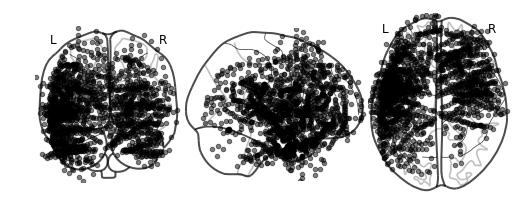

In [33]:
ni_plt.plot_connectome(np.eye(catfr_locs.shape[0]), catfr_locs,
                       node_kwargs={'alpha':.5, 'edgecolors': None},
                       node_size=20, node_color='k')

## All within

In [34]:
all_subject = np.array([])
all_within = np.array([])
all_across = np.array([])
all_R = np.array([])
for i , item in enumerate(RAM_df['Subject'].values):
    #print(item.split('_')[0])
    all_subject = np.append(all_subject, item)
    all_within = np.append(all_within, RAM_df['W_w_w'].iloc[i])
    all_across = np.append(all_across, RAM_df['W_a_w'].iloc[i])
    all_R = np.append(all_R, RAM_df['R'].iloc[i])

In [35]:
corr_all_df = pd.DataFrame()
corr_all_df['Subject'] = all_subject
corr_all_df['W_w_w'] = plot.r2z(all_within)
corr_all_df['W_a_w'] = plot.r2z(all_across)
corr_all_df['R'] = all_R

In [36]:
grouped_all_mean = corr_all_df.groupby('Subject')['W_w_w','W_a_w'].mean()

In [37]:
grouped_all_mean.shape

(24, 2)

In [38]:
from scipy import stats
grouped_results = corr_all_df.groupby('Subject')['W_w_w', 'W_a_w'].mean()
t_stat_group = stats.ttest_rel(grouped_results['W_a_w'],grouped_results['W_w_w'])

In [39]:
t_stat_group

Ttest_relResult(statistic=6.930163974276389, pvalue=4.5901965099743084e-07)

In [40]:
grouped_results.head()

,W_w_w,W_a_w
Subject,,
0.0,0.219335,0.824195
1.0,0.086401,0.505154
2.0,0.091786,1.185209
3.0,0.089896,0.607879
4.0,0.412031,1.435772


In [41]:
corr_by_subject = np.array([])
R_locs = []
subj_by_subject = np.array([])
for i, s in enumerate(grouped_all_mean.index):


    sub_locs = plot.compile_df_locs(corr_all_df['R'][corr_all_df['Subject'] == s])

    if R_locs == []:
        R_locs = sub_locs 
    else:

        R_locs = np.vstack((R_locs, sub_locs))

    sub_corr = np.atleast_2d(grouped_all_mean['W_a_w'][i])
 
    corr_by_subject = np.append(corr_by_subject, np.array([grouped_all_mean['W_a_w'][i]]* np.shape(sub_locs)[0]))
    
    subj_by_subject = np.append(subj_by_subject, np.array([str(s)]* np.shape(sub_locs)[0]))



bestloc_all_df = pd.DataFrame()
bestloc_all_df['Correlation'] = plot.z2r(corr_by_subject)
bestloc_all_df['Subject'] = subj_by_subject
bestloc_all_df['R'] = None



In [42]:
# for i in range(bestloc_all_df.shape[0]):
#     bestloc_all_df['R'][i] = str(R_locs[i])

# bestloc_all_df.to_csv(os.path.join(ram_data_dir, 'best_locs.csv'))

In [43]:
bestloc_all_df = pd.read_csv(os.path.join(ram_data_dir,'best_locs.csv'))

In [44]:
bestloc_all_df.head()

,Unnamed: 0,Correlation,Subject,R
0,0,0.677347,0.0,[-54.86 15.87 40.38]
1,1,0.677347,0.0,[-38.79 51.43 47.05]
2,2,0.677347,0.0,[-52.44 24.4 43.61]
3,3,0.677347,0.0,[-38.79 51.43 47.05]
4,4,0.677347,0.0,[-43.98 42.16 46.89]


## Plot most informative location (average correlation of subject with electrodes within 5 mni of each location in 4mm brain)

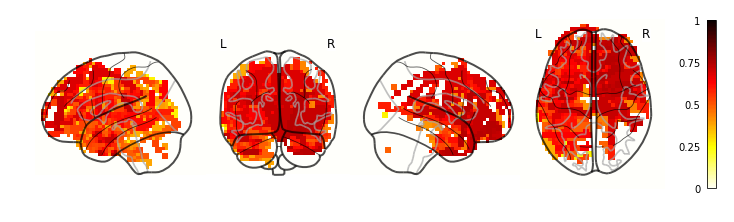

In [45]:
plot.most_informative_locs_plot(bestloc_all_df, vox_size=4, width=5)

## Same but for 20 

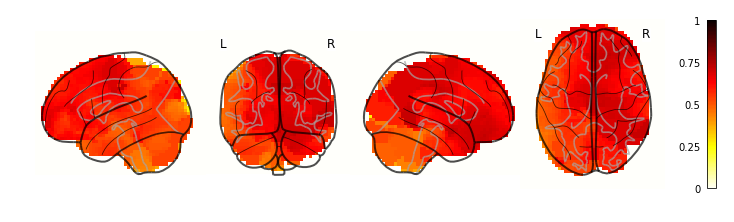

In [46]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.most_informative_locs_plot(bestloc_all_df, vox_size=4, width=20, outfile=outfile)

In [47]:
most_info_all = plot.most_informative_locs(bestloc_all_df, vox_size=4, width=20)

## Scatter plot comparing pyfr and all ram

In [48]:
best_locs_df = pd.DataFrame()
best_locs_df['RAM'] = most_info_all
best_locs_df['PyFR'] = most_info_pyfr
best_locs_df.dropna(inplace=True)

<Figure size 1332x1332 with 0 Axes>

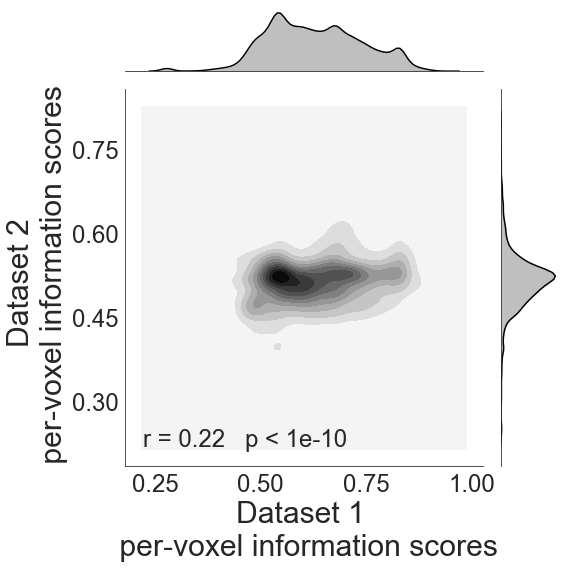

In [49]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.plot_2d_corr_hist(best_locs_df, outfile=outfile)

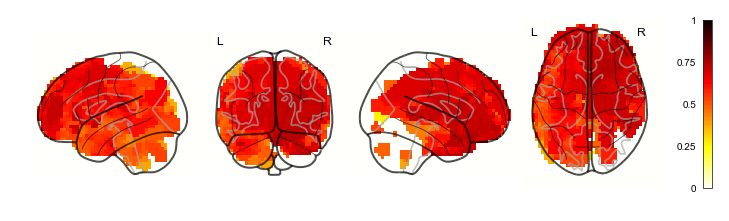

In [50]:
plot.most_informative_locs_plot(bestloc_all_df, vox_size=4, width=10, outfile=None)

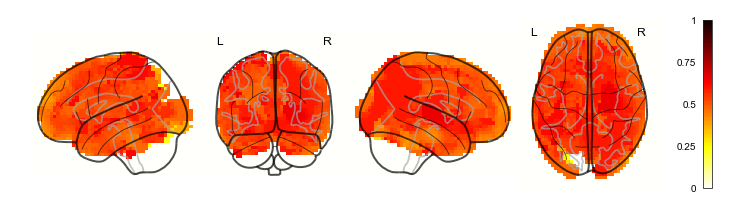

In [51]:
plot.most_informative_locs_plot(bestloc_pyfr_df, vox_size=4, width=10, outfile=None)

In [160]:
best_locs_mask = pd.DataFrame()
best_locs_mask['RAM'] = most_info_all
best_locs_mask['PyFR'] = most_info_pyfr


In [161]:
best_locs_mask.shape[0]/10

3468.6

In [162]:
best_locs_mask['RAM_ranked'] = best_locs_mask['RAM'].rank(ascending=1)

best_locs_mask['RAM_ranked'].head()

RAM_mask = ~np.logical_or(best_locs_mask['RAM_ranked'].isnull(), best_locs_mask['RAM_ranked'] >= 3468)

In [163]:
best_locs_mask['PyFR_ranked'] = best_locs_mask['PyFR'].rank(ascending=1)

best_locs_mask['PyFR_ranked'].head()

PyFR_mask = ~np.logical_or(best_locs_mask['PyFR_ranked'].isnull(), best_locs_mask['PyFR_ranked'] >= 3468)

In [164]:
intersect = PyFR_mask.astype('int64') + RAM_mask.astype('int64')

In [165]:
masked_best_locs = intersect>1

In [166]:
np.sum(masked_best_locs)

525

In [167]:
best_locs_mask['RAM'][masked_best_locs].head()

47     0.466161
59     0.469356
208    0.488523
244    0.455067
245    0.455067
Name: RAM, dtype: float64

In [168]:
best_locs_mask['PyFR'][masked_best_locs].head()

47     0.454601
59     0.453620
208    0.450609
244    0.448365
245    0.448226
Name: PyFR, dtype: float64

In [169]:
vox_size=4
width=20

sub_nii = se.load('std', vox_size=vox_size)
sub_locs = sub_nii.get_locs().values

In [170]:
sub_nii.save('/Users/lucyowen/Desktop/4mm_brain.nii')

In [171]:
bo_nii = se.Brain(data=np.atleast_2d(masked_best_locs ), locs=sub_locs)

In [172]:
bo_nii.get_data()

,0,1,2,3,4,5,6,7,8,9,...,34676,34677,34678,34679,34680,34681,34682,34683,34684,34685
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [173]:
nii_bo = se.helpers._brain_to_nifti(bo_nii, sub_nii)

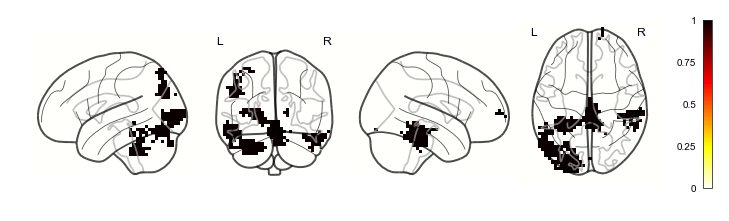

In [174]:

display = ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')

In [ ]:
bo_nii = se.Brain(data=np.atleast_2d(plot.z2r(most_info_pyfr)), locs=sub_locs)

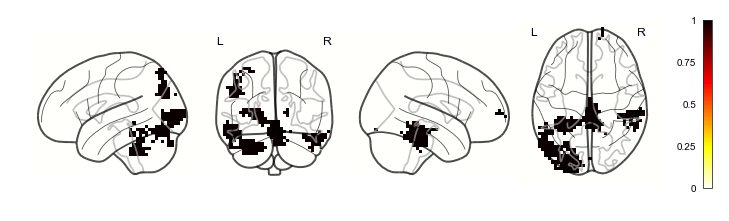

In [77]:

mask_nii = se.Brain(data=np.atleast_2d(masked_best_locs), locs=sub_locs)
nii_mask = se.helpers._brain_to_nifti(mask_nii, sub_nii)
ni_plt.plot_glass_brain(nii_mask, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')

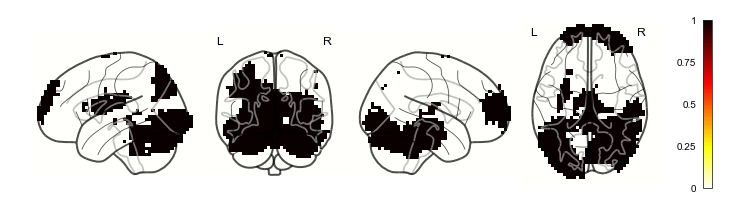

In [84]:
mask_nii = se.Brain(data=np.atleast_2d(mask['PyFR'].astype('int64')), locs=sub_locs)

nii_mask = se.helpers._brain_to_nifti(mask_nii, sub_nii)

ni_plt.plot_glass_brain(nii_mask, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')

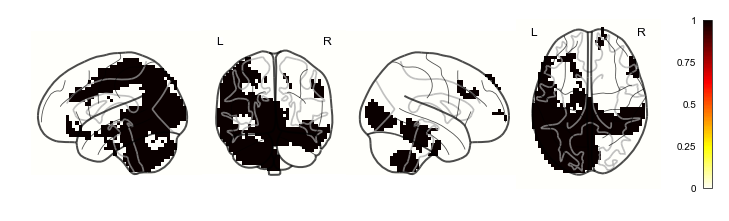

In [85]:
mask_nii = se.Brain(data=np.atleast_2d(mask['RAM'].astype('int64')), locs=sub_locs)

nii_mask = se.helpers._brain_to_nifti(mask_nii, sub_nii)

ni_plt.plot_glass_brain(nii_mask, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')

In [176]:
most_info_pyfr_10 = plot.most_informative_locs(bestloc_pyfr_df, vox_size=4, width=10)

In [177]:
most_info_all_10 = plot.most_informative_locs(bestloc_all_df, vox_size=4, width=10)

In [178]:
best_locs_mask_10 = pd.DataFrame()
best_locs_mask_10['RAM'] = most_info_all_10
best_locs_mask_10['PyFR'] = most_info_pyfr_10


In [179]:
ranked_10 = best_locs_mask_10.rank()

In [180]:
ranked_10['RAM'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: RAM, dtype: float64

In [185]:
mask_10 = ~np.logical_or(ranked_10.isnull(), ranked_10 >= 3468)

In [186]:
intersect_10 = mask_10['PyFR'].astype('int64') + mask_10['RAM'].astype('int64')

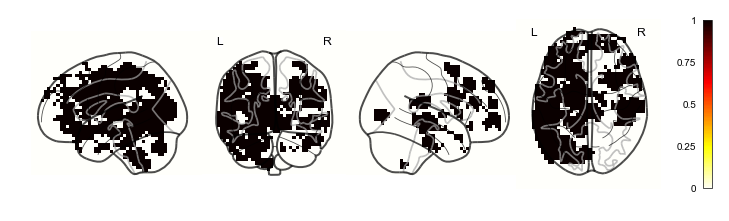

In [187]:
mask_nii = se.Brain(data=np.atleast_2d(mask_10['RAM'].astype('int64')), locs=sub_locs)

nii_mask = se.helpers._brain_to_nifti(mask_nii, sub_nii)

ni_plt.plot_glass_brain(nii_mask, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')

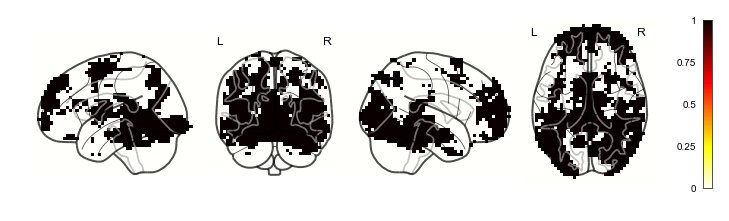

In [188]:
mask_nii = se.Brain(data=np.atleast_2d(mask_10['PyFR'].astype('int64')), locs=sub_locs)

nii_mask = se.helpers._brain_to_nifti(mask_nii, sub_nii)

ni_plt.plot_glass_brain(nii_mask, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')

In [189]:
masked_best_locs_10 = intersect_10>1

In [190]:

mask_nii_10 = se.Brain(data=np.atleast_2d(masked_best_locs_10), locs=sub_locs)

In [191]:
nii_mask_10 = se.helpers._brain_to_nifti(mask_nii_10, sub_nii)

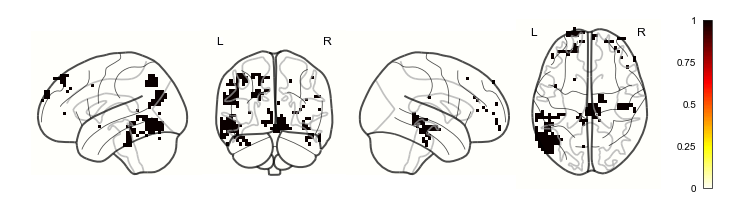

In [192]:
ni_plt.plot_glass_brain(nii_mask_10, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')

In [193]:
nii_mask_10.save('/Users/lucyowen/Desktop/10_width.nii')

In [96]:
bo_nii = se.Brain(data=np.atleast_2d(plot.z2r(most_info_pyfr)), locs=sub_locs)

In [97]:
nii_bo = se.helpers._brain_to_nifti(bo_nii, sub_nii)

In [ ]:

display = ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')